In [ ]:
!pip install matplotlib numpy pandas SciencePlots

In [ ]:
import json
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import pandas as pd
from typing import cast, Dict, Callable
from format import TimeStampEntity, StepLogEntity, MessageLogEntity, Result, List, Literal, Union
import scienceplots as _
from matplotlib.figure import Figure
from matplotlib.axes import Axes


# Get the directory of the current file
current_dir = os.getcwd()

In [ ]:
# # Construct the path to the directory where publish.py is located
# publish_dir = os.path.join(current_dir, "pyblish")

# # Append the directory to sys.path
# sys.path.append(publish_dir)

# # Now you can import the publish module
# import publish

In [11]:
# Load data from all the log files
def load_data_from_files(directory):
    dir_list = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    if len(dir_list) == 0:
        # use the directory as the only directory
        dir_list = [directory]
    for d in dir_list:
        dir_path = os.path.join(directory, d)
        log_files = sorted([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
        print(f"Loading {len(log_files)} log files from {dir_path}")
        for log_file in log_files:
            log_file_path = os.path.join(dir_path, log_file)
            with open(log_file_path, "r") as file:
                data = json.load(file)
                # print(f"File [{log_file}] loaded: {data['dataHandling']}")
                yield data

def get_full_log_key(log:Result):
    return f"{log['numberOfSimulatedEvents']}_{log['numberOfBins']}_{log['particleType']}_{log['dataHandling']}_{log['targetFrames']}_{log['browser']}"

def serialize_data(dir_path:str):
    # SET THE PATH TO THE LOG FILE DIRECTORY
    log_dir = os.path.join(current_dir, dir_path )
    data = {}
    for log in load_data_from_files(log_dir):
        result_log = cast(Result, log)
        # create a new key for the data
        log_key = get_full_log_key(result_log)
        if(log_key not in data):
            data[log_key] = [result_log]
        else:
            data[log_key].append(result_log)
    
    return data

In [12]:
all_electrons_serialized_data: Dict[str, Result] = serialize_data("logs\\allElectronsScenario\\")

Loading 4400 log files from d:\Repozytoria\geant4-wasm-performance\result_plot\logs\allElectronsScenario\


In [13]:
# print out dictionary size and keys separated by new lines
print(f"Dictionary size: {len(all_electrons_serialized_data)}")
print("\n".join(all_electrons_serialized_data.keys()))

Dictionary size: 220
1_1_electron_all_processed_0_Vivaldi_6.8
1_1_electron_all_processed_0.5_Vivaldi_6.8
1_1_electron_all_raw_0_Vivaldi_6.8
1_1_electron_all_raw_0.5_Vivaldi_6.8
1_16_electron_all_processed_0_Vivaldi_6.8
1_16_electron_all_processed_0.5_Vivaldi_6.8
1_16_electron_all_raw_0_Vivaldi_6.8
1_16_electron_all_raw_0.5_Vivaldi_6.8
1_256_electron_all_processed_0_Vivaldi_6.8
1_256_electron_all_processed_0.5_Vivaldi_6.8
1_256_electron_all_raw_0_Vivaldi_6.8
1_256_electron_all_raw_0.5_Vivaldi_6.8
1_4_electron_all_processed_0_Vivaldi_6.8
1_4_electron_all_processed_0.5_Vivaldi_6.8
1_4_electron_all_raw_0_Vivaldi_6.8
1_4_electron_all_raw_0.5_Vivaldi_6.8
1_64_electron_all_processed_0_Vivaldi_6.8
1_64_electron_all_processed_0.5_Vivaldi_6.8
1_64_electron_all_raw_0_Vivaldi_6.8
1_64_electron_all_raw_0.5_Vivaldi_6.8
1024_1_electron_all_processed_0_Vivaldi_6.8
1024_1_electron_all_processed_0.5_Vivaldi_6.8
1024_1_electron_all_raw_0_Vivaldi_6.8
1024_1_electron_all_raw_0.5_Vivaldi_6.8
1024_16_electro

In [14]:
# print out the first log in readable format
first_key = list(all_electrons_serialized_data.keys())[0]
first_log = all_electrons_serialized_data[first_key]
print(json.dumps(first_log, indent=4))

[
    {
        "iteration": "0",
        "numberOfSimulatedEvents": "1",
        "numberOfBins": "1",
        "particleType": "electron",
        "dataHandling": "all_processed",
        "targetFrames": "0",
        "browser": "Vivaldi_6.8",
        "resolution": "2560x1440",
        "timeStamps": [
            [
                "testStart",
                44.69999999925494
            ],
            [
                "workerStart",
                188.89999999850988
            ],
            [
                "simulationStart",
                376.70014648512006
            ],
            [
                "simulationEnd",
                1070.8001464828849
            ],
            [
                "testEnd",
                1083.8999999985099
            ]
        ],
        "stepLogs": [
            {
                "handleStart": 199.39999999850988,
                "optimizeStart": null,
                "renderStart": null,
                "stepEnd": 199.5,
                "

In [26]:
def plot_total_time_taken(fig: Figure, ax: Axes, data_list: List[Dict[str,Result]], series_criteria: Dict[str, List[any]], label_fn: Callable[[Result], str]=get_full_log_key):
    series = {}
    lines = []
    for data in data_list:
        for _, log in data.items():
            label = label_fn(log[0])
            if not all(log[0][k] in v for k, v in series_criteria.items()):
                continue
            if series.get(label) is None:
                series[label] = {"x": [], "y": [], "e": []}
            series[label]["x"].append(int(log[0]["numberOfSimulatedEvents"]))
            # total time taken is a difference between the last and first timestamp
            all_times = [time_stamps["timeStamps"][-1][1] - time_stamps["timeStamps"][0][1] for time_stamps in log]
            # get average total and std deviation
            average_time_taken = np.mean(all_times)
            std_dev = np.std(all_times)
            
            series[label]["y"].append(average_time_taken)
            series[label]["e"].append(std_dev)
            # print(f"Plotting {_}", average_time_taken, std_dev)
    # sort the x and y values in all series based on x
    for k, s in series.items():
        s["x"], s["y"], s["e"] = zip(*sorted(zip(s["x"], s["y"], s["e"])))
        line = ax.plot(s["x"], s["y"], label=k)
        lines.append(line)
        # fill in area between the error bars
        ax.fill_between(s["x"], np.array(s["y"]) - np.array(s["e"]), np.array(s["y"]) + np.array(s["e"]), alpha=0.2)
    return zip(series.keys(), lines)

Tytuł: Porównanie czasów trwania symulacji oraz wizualizacji dla różnych środowisk przeglądarkowych


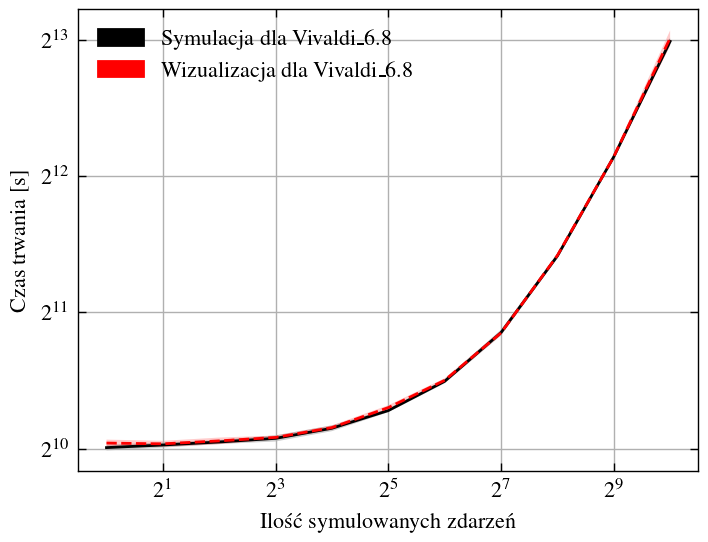

In [34]:
with plt.style.context(['science','ieee']):
    fig, ax = plt.subplots(figsize=(4, 3))
    fig.dpi = 200
    series_criteria = dict(dataHandling=['all_raw','all_processed','none'], particleType=['electron'], numberOfBins=['256'], targetFrames=['0'])
    label_fn = lambda log: f'Wizualizacja dla {log["browser"]}' if log['dataHandling'] == 'all_raw' else f'Symulacja dla {log["browser"]}'
    plots = plot_total_time_taken(fig, ax, [all_electrons_serialized_data], series_criteria, label_fn)
    ax.set_xlabel('Ilość symulowanych zdarzeń')
    ax.set_ylabel('Czas trwania [s]')
    print('Tytuł: Porównanie czasów trwania symulacji oraz wizualizacji dla różnych środowisk przeglądarkowych')
    # ax.set_title("Total time taken vs Number of simulated events")
    ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=2)
    ax.grid()
    ax.legend(handles=[mpatches.Patch(color=line[0].get_color(), label=k) for k, line in plots])
    plt.show()